In [ ]:
# Sign in to Google Drive
# from google.colab import drive
# drive.mount('/content/drive')

In [1]:
import os
os.listdir()

['.config', 'drive', 'sample_data']

In [2]:
# use this to upload files
def upload():
  from google.colab import files
  uploaded = files.upload() 
  for name, data in uploaded.items():
    with open(name, 'wb') as f:
      f.write(data)
      print ('saved file', name)

# use this to download a file  
def download(path):
  from google.colab import files
  files.download(path)

In [3]:
#Git clone
!git clone https://github.com/sumedhravi/YOLOv3-GTSDB.git
home_dir = os.getcwd()

Cloning into 'YOLOv3-GTSDB'...
remote: Enumerating objects: 22, done.
remote: Counting objects: 100% (22/22), done.
remote: Compressing objects: 100% (18/18), done.
remote: Total 22 (delta 7), reused 0 (delta 0), pack-reused 0
Unpacking objects: 100% (22/22), done.


In [4]:
# Directory
directory = home_dir + '/GTSDB'
if not os.path.exists(directory):
    os.makedirs(directory)
    print("Directory '% s' created" % directory)
os.listdir()

Directory '/content/GTSDB' created


['.config', 'drive', 'YOLOv3-GTSDB', 'GTSDB', 'sample_data']

In [5]:
# Flags 
train_individual_classes = False # To train for 43 classes instead of the 4 main parent classes
train = True # If the model needs to be trained
load_saved_weights = True #To load the best weights from the previously trained model 

In [7]:
# Extract zipped folder
from zipfile import ZipFile
  
# specifying the zip file name
# file_name = 'drive/MyDrive/FullIJCNN2013.zip'
repo_folder = home_dir + '/YOLOv3-GTSDB' ##REPO NAME
dataset_path = '/content/drive/MyDrive/FullIJCNN2013.zip'  ## Change the path if on local machine
  
# opening the zip file in READ mode
with ZipFile(dataset_path, 'r') as zip:
    # extracting all the files
    print('Extracting the contents now...')
    zip.extractall(directory)
    print('Done!')

Extracting the contents now...
Done!


In [8]:
import numpy as np
import pandas as pd
from glob import glob
import shutil
import cv2
import torch
from torch.utils import data
from PIL import Image
import torchvision
from torchvision import transforms
import matplotlib.pyplot as plt

In [9]:
# To parse the bounding box coordinates and the class values for the traffic signs labelled in individual images from the text file
txt = np.genfromtxt(directory + '/FullIJCNN2013/gt.txt',delimiter =';', dtype= None,encoding=None)

#Creating a dictionary with image names as key and annotations as value
image_info ={}
for i in range (0,len(txt)):
    #Image name is first element of annotation file
    img_name = txt[i][0]
    # 4 Coordinates
    target = [txt[i][1],txt[i][2],txt[i][3],txt[i][4],txt[i][5]]
    #Last element is the class number
    # clas = txt[i][-1]
    #If multiple objects, store coordinates and classes as list of lists
    if(img_name in image_info):
        image_info[img_name].append(target)
    else:
        image_info[img_name] = [target]
print(image_info['00001.ppm'])
print("Number of Images: " + str(len(image_info)))

[[983, 388, 1024, 432, 40], [386, 494, 442, 552, 38], [973, 335, 1031, 390, 13]]
Number of Images: 741


In [10]:
# To train for 4 classes instead of 43 classes  
class_map = {0: [0,1,2,3,4,5,7,8,9,10,15,16],  ### (prohibitory)
  1: [33,34,35,36,37,38,39,40], ### mandatory
  2: [11, 18,19,20,21,22,23,24,25,26,27,28,29,30,31], ### Danger
  3: [6,12,13,14,17,32,41,42] ### Other
}

import copy
def get_new_class(original_class, class_map):
    for key, values in class_map.items():
        if original_class in values:
            return key

    return len(class_map.keys()) - 1

def update_classes(original_data, class_map):
    new_data = copy.deepcopy(original_data)
    for key, values in new_data.items():
        for value in values:
            value[-1] = get_new_class(value[-1], class_map)

    return (new_data)

if not train_individual_classes:
  image_info = update_classes(image_info, class_map)
  print(image_info)

{'00000.ppm': [[774, 411, 815, 446, 2]], '00001.ppm': [[983, 388, 1024, 432, 1], [386, 494, 442, 552, 1], [973, 335, 1031, 390, 3]], '00002.ppm': [[892, 476, 1006, 592, 1]], '00003.ppm': [[742, 443, 765, 466, 0], [742, 466, 764, 489, 0], [737, 412, 769, 443, 2]], '00004.ppm': [[898, 342, 967, 409, 2], [906, 407, 955, 459, 0]], '00005.ppm': [[1172, 164, 1284, 278, 0]], '00006.ppm': [[926, 350, 989, 414, 0]], '00007.ppm': [[825, 406, 864, 445, 0]], '00008.ppm': [[785, 460, 811, 486, 0], [779, 424, 816, 461, 3]], '00009.ppm': [[925, 466, 949, 490, 0]], '00010.ppm': [[1193, 358, 1269, 436, 3]], '00011.ppm': [[720, 338, 770, 398, 0], [710, 265, 780, 342, 2]], '00012.ppm': [[979, 364, 1034, 418, 0]], '00013.ppm': [[1043, 281, 1120, 356, 0]], '00014.ppm': [[712, 492, 732, 511, 2]], '00015.ppm': [[770, 426, 808, 462, 2]], '00016.ppm': [[901, 421, 959, 478, 3]], '00017.ppm': [[908, 302, 1031, 408, 2], [575, 495, 598, 515, 2]], '00018.ppm': [[950, 455, 981, 486, 0]], '00019.ppm': [[838, 366, 896

In [11]:
image_info

{'00000.ppm': [[774, 411, 815, 446, 2]],
 '00001.ppm': [[983, 388, 1024, 432, 1],
  [386, 494, 442, 552, 1],
  [973, 335, 1031, 390, 3]],
 '00002.ppm': [[892, 476, 1006, 592, 1]],
 '00003.ppm': [[742, 443, 765, 466, 0],
  [742, 466, 764, 489, 0],
  [737, 412, 769, 443, 2]],
 '00004.ppm': [[898, 342, 967, 409, 2], [906, 407, 955, 459, 0]],
 '00005.ppm': [[1172, 164, 1284, 278, 0]],
 '00006.ppm': [[926, 350, 989, 414, 0]],
 '00007.ppm': [[825, 406, 864, 445, 0]],
 '00008.ppm': [[785, 460, 811, 486, 0], [779, 424, 816, 461, 3]],
 '00009.ppm': [[925, 466, 949, 490, 0]],
 '00010.ppm': [[1193, 358, 1269, 436, 3]],
 '00011.ppm': [[720, 338, 770, 398, 0], [710, 265, 780, 342, 2]],
 '00012.ppm': [[979, 364, 1034, 418, 0]],
 '00013.ppm': [[1043, 281, 1120, 356, 0]],
 '00014.ppm': [[712, 492, 732, 511, 2]],
 '00015.ppm': [[770, 426, 808, 462, 2]],
 '00016.ppm': [[901, 421, 959, 478, 3]],
 '00017.ppm': [[908, 302, 1031, 408, 2], [575, 495, 598, 515, 2]],
 '00018.ppm': [[950, 455, 981, 486, 0]],
 '

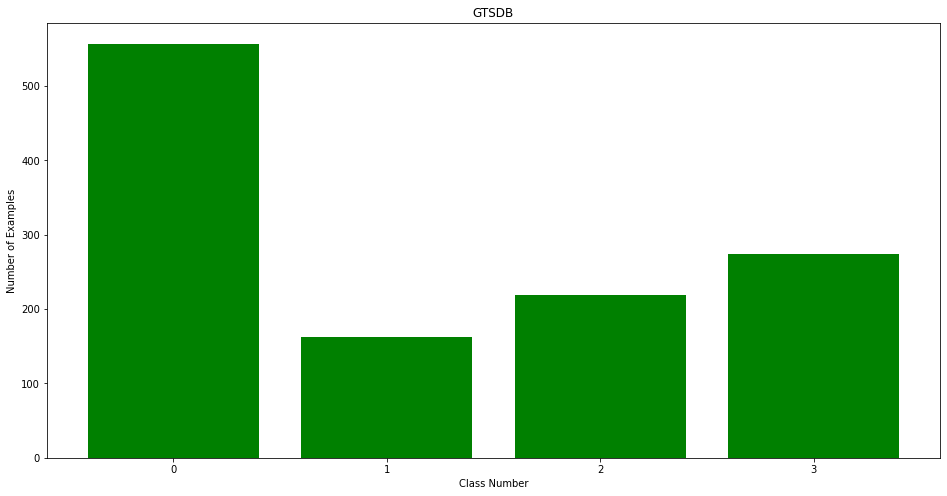

In [12]:
# Checking Class Distribution
class_list = {}

for image, value in image_info.items():
    for box in value:
        cls = box[-1]
        if cls in class_list:
            class_list[cls] += 1
        else:
            class_list[cls] = 1
                
class_list = dict(sorted(class_list.items(), key = lambda item: item[0]))

xx = []
yy = []
for i in class_list:
    xx.append(str(i))
    yy.append(class_list[i])

x_pos = [i for i, _ in enumerate(xx)]

fig, ax = plt.subplots(1,1,figsize=(16,8))
ax.bar(x_pos, yy, color='green')
plt.xlabel("Class Number")
plt.ylabel("Number of Examples")
plt.title("GTSDB")
plt.xticks(x_pos, xx)

plt.show()

In [13]:
data_dir = directory
train_img_dir = data_dir + '/FullIJCNN2013/'
image_dir_jpg = (data_dir + '/GTSDB_jpg/')
if os.path.exists(image_dir_jpg):
    shutil.rmtree(image_dir_jpg)
os.makedirs(image_dir_jpg)

# Convert ppm files to jpeg files and store them in a folder
for file, values in image_info.items():
    ppm_file = train_img_dir + file
    target =  image_dir_jpg + file
    if ppm_file[-3:] == "ppm":
        # img_path = os.path.join(train_img_dir, img_name)
        img = Image.open(ppm_file)
        jpg_path = target[:-3]+'jpg'
        # print(jpg_path)
        img.save(jpg_path)
    else:
        shutil.copyfile(ppm_file, target)

In [14]:
os.listdir(data_dir)

['GTSDB_jpg', 'FullIJCNN2013']

In [15]:
print(len(os.listdir(data_dir + '/GTSDB_jpg/')))
print(len(image_info))

741
741


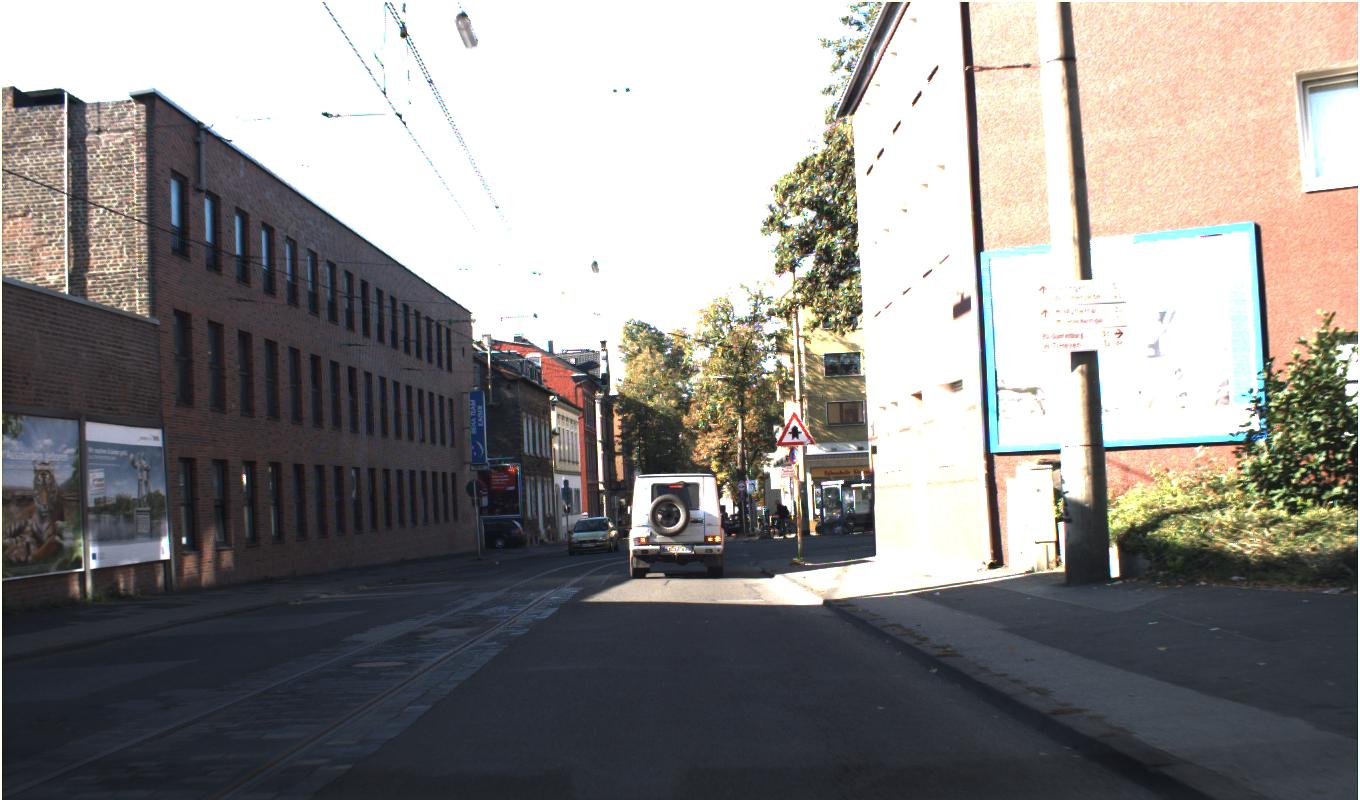

In [16]:
# Test if image is getting displayed properly
from IPython.display import Image as displayImage, display
display(displayImage(data_dir + '/GTSDB_jpg/00000.jpg'))

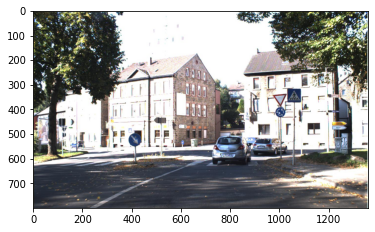

In [17]:
img = Image.open(data_dir + '/GTSDB_jpg/00001.jpg')
plt.imshow(img)

In [18]:
# Method to visualize bounding boxes on the respective images from the coordinate data
def draw_boxes(img, boxes, color = (0,255,0)):
    image= np.array(img)
    for box in boxes:
        # x1, y1, x2, y2 = from_yolo_to_cor(box, shape)
        cv2.rectangle(image, (box[0], box[1]), (box[2], box[3]), color, 3)
    plt.figure(figsize = (12,12))
    plt.imshow(image, interpolation='nearest')
    # plt.imshow(image, figsize=(12,12))

In [19]:
# Method to convert given (x_min, y_min, x_max, y_max) format to YOLO format (center_x, center_y, width, height)
def convert_labels(path, x1, y1, x2, y2):
    """
    Definition: Parses label files to extract label and bounding box
        coordinates.  Converts (x_min, y_min, x_max, y_max) format to
        (center_x, center_y, width, height) normalized YOLO format.
    """
    def sorting(l1, l2):
        if l1 > l2:
            lmax, lmin = l1, l2
            return lmax, lmin
        else:
            lmax, lmin = l2, l1
            return lmax, lmin
    size = get_img_shape(path)
    xmax, xmin = sorting(x1, x2)
    ymax, ymin = sorting(y1, y2)
    dw = 1./size[1]
    dh = 1./size[0]
    x = (xmin + xmax)/2.0
    y = (ymin + ymax)/2.0
    w = xmax - xmin
    h = ymax - ymin
    x = x*dw
    w = w*dw
    y = y*dh
    h = h*dh
    return [x,y,w,h]

def get_img_shape(path):
    img = cv2.imread(path)
    try:
        return img.shape
    except AttributeError:
        print('error! ', path)
        return (None, None, None)

In [20]:
# Method to convert YOLO coordinates back to normal format
def from_yolo_to_cor(box, shape):
    img_h, img_w, _ = shape
    # x1, y1 = ((x + witdth)/2)*img_width, ((y + height)/2)*img_height
    # x2, y2 = ((x - witdth)/2)*img_width, ((y - height)/2)*img_height
    x1, y1 = int((box[0] + box[2]/2)*img_w), int((box[1] + box[3]/2)*img_h)
    x2, y2 = int((box[0] - box[2]/2)*img_w), int((box[1] - box[3]/2)*img_h)
    return x1, y1, x2, y2

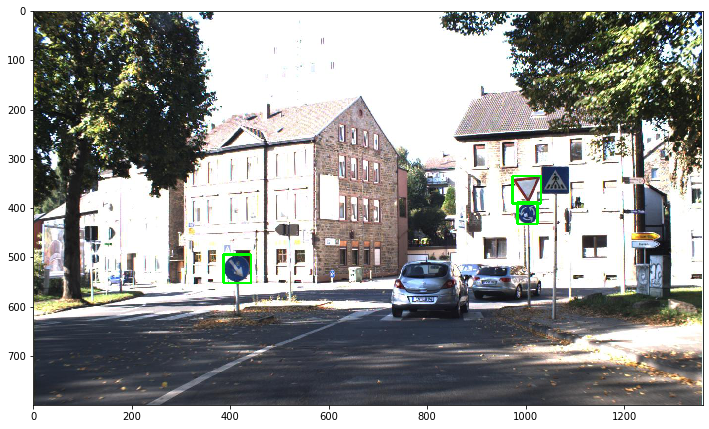

In [21]:
#Visualizing original objects
draw_boxes(img, image_info['00001.ppm'])

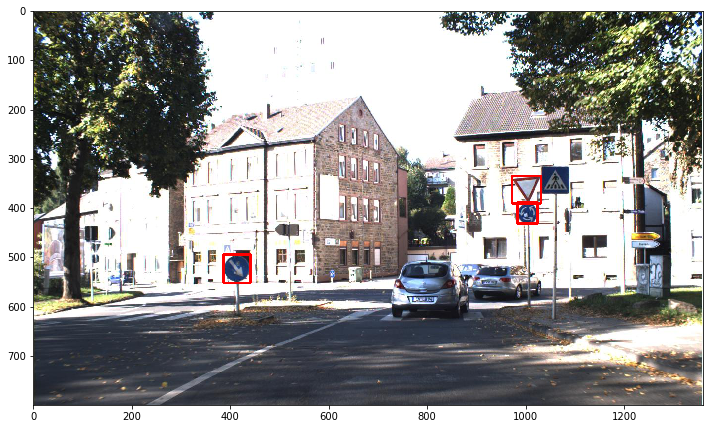

In [22]:
# Verifying if coordinates have been properly converted to YOLO coordinates
new_coords = []
for box in image_info['00001.ppm']:
    new_coords.append(convert_labels(data_dir + '/GTSDB_jpg/00001.jpg', box[0], box[1], box[2], box[3]))

converted_coords = []
for box in new_coords:
    x1, y1, x2, y2 = from_yolo_to_cor(box, (800,1360,3))
    converted_coords.append([x1,y1,x2,y2])
    
# Visualizing coordinates converted back from YOLO format
draw_boxes(img, converted_coords, (255,0,0))

In [23]:
# Creating a .txt file for each image containing the box coordinates in YOLO format and the class category of each object on a new line.
files = []
for file in image_info:
    with open(data_dir + '/GTSDB_jpg/{}'.format(file).replace("ppm", "txt"), "w") as outfile:
        for box in image_info[file]:
            box_coords = convert_labels(data_dir + '/GTSDB_jpg/{}'.format(file).replace('ppm', 'jpg'), box[0], box[1], box[2], box[3])
            line = '{} {} {} {} {}'.format(box[-1], box_coords[0], box_coords[1], box_coords[2], box_coords[3])
            outfile.write(line)
            outfile.write('\n')
        outfile.close()

Train has image files with traffic signs numbers: 741
Train has traffic signs class numbers: 43
Train has traffic signs instance numbers: 1213


/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


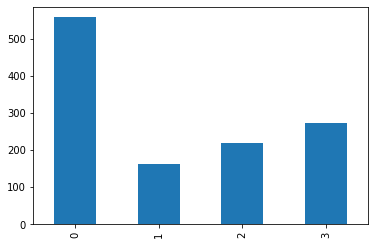

In [24]:
data = pd.read_csv(data_dir + '/FullIJCNN2013/gt.txt', sep=";", header=None)
data.columns = ["img", "x1", "y1", "x2", "y2", "id"]

print("Train has image files with traffic signs numbers:", len(data['img'].unique()))
print("Train has traffic signs class numbers:", len(data['id'].unique()))
print("Train has traffic signs instance numbers:", data['id'].count())
#pd.value_counts(data['id'], sort=False).plot.bar()
# print(pd.value_counts(data['id'], sort=True))

# Training for 4 classes
if not train_individual_classes:
  for i in range(len(data)) :
    for new_class, old_classes in class_map.items():
      if data.iloc[i]['id'] in (old_classes) :
        data['id'].iloc[i] = new_class
data['id'].value_counts().sort_index().plot(kind='bar')

In [25]:
# Creating train and validation sets
X=[]
y=[]
for key, value in image_info.items():
    X.append(key)
    y.append(value[-1][-1])

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
print(len(X_train), len(X_test))

518 223


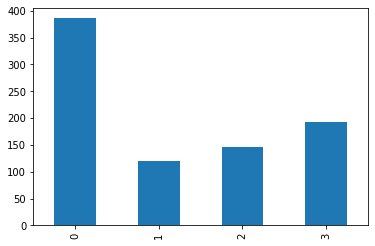

In [26]:
# Visualize training set class distribution
train_values = data[data['img'].isin(X_train)]
train_values['id'].value_counts().sort_index().plot(kind='bar')

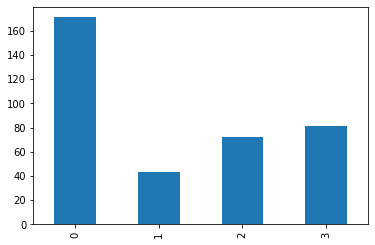

In [27]:
# Visualize validation set class distribution
test_values = data[data['img'].isin(X_test)]
test_values['id'].value_counts().sort_index().plot(kind='bar')

In [53]:
def generate_filenames_txt(files, isTrain):
    """
    Definition: Generate image paths for train or validation 
    and save it in a text file with the corresponding filename.

    files: The image names list
    isTrain(Bool): Whether the file list is for training or validation.
    """
    image_files = []
    for filename in files:
        image_files.append("data/obj/" + filename.replace("ppm","jpg"))
    file_path = ""
    if isTrain: file_path = home_dir + "/train.txt"
    else: file_path = home_dir + "/val.txt"
    with open(file_path, "w") as outfile:
        for image in image_files:
            outfile.write(image)
            outfile.write("\n")
        outfile.close()

In [54]:
generate_filenames_txt(X_train, True)
generate_filenames_txt(X_test, False)

**Setting up Darknet Repository**

In [32]:
# clone darknet repo
!git clone https://github.com/AlexeyAB/darknet

Cloning into 'darknet'...
remote: Enumerating objects: 15298, done.
remote: Total 15298 (delta 0), reused 0 (delta 0), pack-reused 15298
Receiving objects: 100% (15298/15298), 13.68 MiB | 16.54 MiB/s, done.
Resolving deltas: 100% (10389/10389), done.


In [33]:
# change makefile to have GPU and OPENCV enabled
%cd darknet
!sed -i 's/OPENCV=0/OPENCV=1/' Makefile
!sed -i 's/GPU=0/GPU=1/' Makefile
!sed -i 's/CUDNN=0/CUDNN=1/' Makefile
!make

/content/darknet


In [34]:
# verify CUDA
!/usr/local/cuda/bin/nvcc --version

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2020 NVIDIA Corporation
Built on Wed_Jul_22_19:09:09_PDT_2020
Cuda compilation tools, release 11.0, V11.0.221
Build cuda_11.0_bu.TC445_37.28845127_0


In [35]:
# get yolov3 pretrained coco dataset weights
!wget https://pjreddie.com/media/files/yolov3.weights

--2021-08-08 21:20:41--  https://pjreddie.com/media/files/yolov3.weights
Resolving pjreddie.com (pjreddie.com)... 128.208.4.108
Connecting to pjreddie.com (pjreddie.com)|128.208.4.108|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 248007048 (237M) [application/octet-stream]
Saving to: ‘yolov3.weights’

yolov3.weights      100%[===================>] 236.52M  74.9MB/s    in 3.4s    

2021-08-08 21:20:45 (70.3 MB/s) - ‘yolov3.weights’ saved [248007048/248007048]



In [36]:
# define helper functions
def imShow(path):
  import cv2
  import matplotlib.pyplot as plt
  %matplotlib inline

  image = cv2.imread(path)
  height, width = image.shape[:2]
  resized_image = cv2.resize(image,(3*width, 3*height), interpolation = cv2.INTER_CUBIC)

  fig = plt.gcf()
  fig.set_size_inches(18, 10)
  plt.axis("off")
  plt.imshow(cv2.cvtColor(resized_image, cv2.COLOR_BGR2RGB))
  plt.show()

mkdir -p ./obj/
mkdir -p backup
chmod +x *.sh
g++ -std=c++11 -std=c++11 -Iinclude/ -I3rdparty/stb/include -DOPENCV `pkg-config --cflags opencv4 2> /dev/null || pkg-config --cflags opencv` -DGPU -I/usr/local/cuda/include/ -DCUDNN -Wall -Wfatal-errors -Wno-unused-result -Wno-unknown-pragmas -fPIC -Ofast -DOPENCV -DGPU -DCUDNN -I/usr/local/cudnn/include -c ./src/image_opencv.cpp -o obj/image_opencv.o
./src/image_opencv.cpp: In function ‘void draw_detections_cv_v3(void**, detection*, int, float, char**, image**, int, int)’:
./src/image_opencv.cpp:946:23: warning: variable ‘rgb’ set but not used [-Wunused-but-set-variable]
                 float rgb[3];
                       ^~~
./src/image_opencv.cpp: In function ‘void draw_train_loss(char*, void**, int, float, float, int, int, float, int, char*, float, int, int, double)’:
./src/image_opencv.cpp:1147:13: warning: this ‘if’ clause does not guard... [-Wmisleading-indentation]
             if (iteration_old == 0)
             ^~
./src/image_

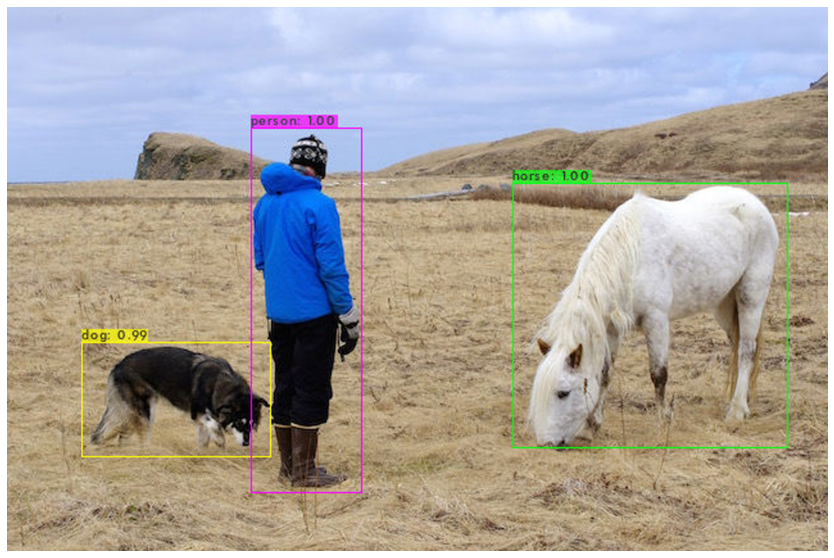

In [39]:
!./darknet detect cfg/yolov3.cfg yolov3.weights data/person.jpg
imShow('predictions.jpg')

In [40]:
print(len(os.listdir(data_dir + '/GTSDB_jpg')))
# print(len(os.listdir(data_dir + 'GTSDB_modified/jpg_images_anot/')))
# print(len(image_info.keys()))

1482


In [ ]:
print(data)

            img   x1   y1    x2   y2  id
0     00000.ppm  774  411   815  446   2
1     00001.ppm  983  388  1024  432   1
2     00001.ppm  386  494   442  552   1
3     00001.ppm  973  335  1031  390   3
4     00002.ppm  892  476  1006  592   1
...         ...  ...  ...   ...  ...  ..
1208  00896.ppm  808  412   846  450   0
1209  00897.ppm  804  526   828  550   3
1210  00898.ppm  323  504   355  536   0
1211  00898.ppm  817  510   849  542   0
1212  00899.ppm  864  484   921  534   2

[1213 rows x 6 columns]


In [41]:
image_dir_jpg

'/content/GTSDB/GTSDB_jpg/'

In [44]:
# Copy image files with annotation text files to  darknet/data/obj folder
%cd /content/
source_dir = image_dir_jpg
target_dir = home_dir + '/darknet/data/obj/'

if not os.path.exists(target_dir):
    os.makedirs(target_dir)
    
file_names = os.listdir(source_dir)
    
for file_name in file_names:
    shutil.copyfile(source_dir + file_name, target_dir+file_name)

/content


In [45]:
len(os.listdir(home_dir + '/darknet/data/obj'))

1482

In [56]:
# Move train.txt and valid.txt to darknet/data folder
if not os.path.exists(home_dir + '/darknet/data/train.txt'):
    shutil.move(home_dir + '/train.txt', home_dir + '/darknet/data/')
if not os.path.exists(home_dir + '/darknet/data/val.txt'):
    shutil.move(home_dir + '/val.txt', home_dir + '/darknet/data/')

In [65]:
# Copy config files to darknet/cfg
if not os.path.exists(home_dir + '/darknet/cfg/yolov3_custom_train_v2.cfg'):
    shutil.copyfile(repo_folder + '/yolov3_custom_train_v2.cfg', home_dir + '/darknet/cfg/yolov3_custom_train_v2.cfg')
if not os.path.exists(home_dir + '/darknet/cfg/yolov3_custom_train_v1.cfg'):
    shutil.copyfile(repo_folder + '/yolov3_custom_train_v1.cfg', home_dir + '/darknet/cfg/yolov3_custom_train_v1.cfg')
# Copy .data files to darknet folder
if not os.path.exists(home_dir + '/darknet/data/obj.data'):
    shutil.copyfile(repo_folder + '/obj.data', home_dir + '/darknet/data/obj.data')
if not os.path.exists(home_dir + '/darknet/data/obj43.data'):
    shutil.copyfile(repo_folder + '/obj43.data', home_dir + '/darknet/data/obj43.data')
# Copy .names file to file to darknet/data
if not os.path.exists(home_dir + '/darknet/data/obj.names'):
    shutil.copyfile(repo_folder + '/obj.names', home_dir + '/darknet/data/obj.names')
if not os.path.exists(home_dir + '/darknet/data/obj43.names'):
    shutil.copyfile(repo_folder + '/obj43.names', home_dir + '/darknet/data/obj43.names')

In [60]:
weights_4 = '/content/drive/MyDrive/yolov3/backup/yolov3_custom_train_v2_best.weights'
weights_43 = '/content/drive/MyDrive/yolov3/backup/yolov3_custom_train_v1_best.weights'

In [61]:
# Path to config files
if not train_individual_classes:
  cfg_file = 'cfg/yolov3_custom_train_v2.cfg'
  data_file = 'data/obj.data'
  weights = weights_4
else:
  cfg_file = 'yolov3_custom_train_v1.cfg'
  data_file = 'data/obj43.data'
  weights = weights_43

In [62]:
# Download weights for model
def train_model():
  if not load_saved_weights:
    if not os.path.exists('/content/darknet/darknet53.conv.74'):
      !wget http://pjreddie.com/media/files/darknet53.conv.74
      shutil.move('darknet53.conv.74', '/content/darknet/')
    # Start with pretrained weights
    !./darknet detector train $data_file $cfg_file darknet53.conv.74 -map -dont_show | tee log.txt
  else:
    # Load saved weights
    !./darknet detector train $data_file $cfg_file $weights -map -dont_show | tee log.txt

In [63]:
%cd darknet
!make
!chmod +x ./darknet

/content/darknet
chmod +x *.sh


In [66]:
if train:
  train_model()

 CUDA-version: 11000 (11020), cuDNN: 7.6.5, GPU count: 1  
 OpenCV version: 3.2.0
 0 : compute_capability = 750, cudnn_half = 0, GPU: Tesla T4 
   layer   filters  size/strd(dil)      input                output
   0 conv     32       3 x 3/ 1    416 x 416 x   3 ->  416 x 416 x  32 0.299 BF
   1 conv     64       3 x 3/ 2    416 x 416 x  32 ->  208 x 208 x  64 1.595 BF
   2 conv     32       1 x 1/ 1    208 x 208 x  64 ->  208 x 208 x  32 0.177 BF
   3 conv     64       3 x 3/ 1    208 x 208 x  32 ->  208 x 208 x  64 1.595 BF
   4 Shortcut Layer: 1,  wt = 0, wn = 0, outputs: 208 x 208 x  64 0.003 BF
   5 conv    128       3 x 3/ 2    208 x 208 x  64 ->  104 x 104 x 128 1.595 BF
   6 conv     64       1 x 1/ 1    104 x 104 x 128 ->  104 x 104 x  64 0.177 BF
   7 conv    128       3 x 3/ 1    104 x 104 x  64 ->  104 x 104 x 128 1.595 BF
   8 Shortcut Layer: 5,  wt = 0, wn = 0, outputs: 104 x 104 x 128 0.001 BF
   9 conv     64       1 x 1/ 1    104 x 104 x 128 ->  104 x 104 x  64 0.177 B

In [67]:
os.listdir(home_dir + '/drive/MyDrive/yolov3/')

['backup', '.ipynb_checkpoints']

In [ ]:
!./darknet detector map $data_file $cfg_file $weights -points 11

 CUDA-version: 11000 (11020), cuDNN: 7.6.5, GPU count: 1  
 OpenCV version: 3.2.0
 0 : compute_capability = 750, cudnn_half = 0, GPU: Tesla T4 
net.optimized_memory = 0 
mini_batch = 1, batch = 8, time_steps = 1, train = 0 
   layer   filters  size/strd(dil)      input                output
   0 Create CUDA-stream - 0 
 Create cudnn-handle 0 
conv     32       3 x 3/ 1    416 x 416 x   3 ->  416 x 416 x  32 0.299 BF
   1 conv     64       3 x 3/ 2    416 x 416 x  32 ->  208 x 208 x  64 1.595 BF
   2 conv     32       1 x 1/ 1    208 x 208 x  64 ->  208 x 208 x  32 0.177 BF
   3 conv     64       3 x 3/ 1    208 x 208 x  32 ->  208 x 208 x  64 1.595 BF
   4 Shortcut Layer: 1,  wt = 0, wn = 0, outputs: 208 x 208 x  64 0.003 BF
   5 conv    128       3 x 3/ 2    208 x 208 x  64 ->  104 x 104 x 128 1.595 BF
   6 conv     64       1 x 1/ 1    104 x 104 x 128 ->  104 x 104 x  64 0.177 BF
   7 conv    128       3 x 3/ 1    104 x 104 x  64 ->  104 x 104 x 128 1.595 BF
   8 Shortcut Layer: 5,  

 CUDA-version: 11000 (11020), cuDNN: 7.6.5, GPU count: 1  
 OpenCV version: 3.2.0
 0 : compute_capability = 750, cudnn_half = 0, GPU: Tesla T4 
net.optimized_memory = 0 
mini_batch = 1, batch = 8, time_steps = 1, train = 0 
   layer   filters  size/strd(dil)      input                output
   0 Create CUDA-stream - 0 
 Create cudnn-handle 0 
conv     32       3 x 3/ 1    416 x 416 x   3 ->  416 x 416 x  32 0.299 BF
   1 conv     64       3 x 3/ 2    416 x 416 x  32 ->  208 x 208 x  64 1.595 BF
   2 conv     32       1 x 1/ 1    208 x 208 x  64 ->  208 x 208 x  32 0.177 BF
   3 conv     64       3 x 3/ 1    208 x 208 x  32 ->  208 x 208 x  64 1.595 BF
   4 Shortcut Layer: 1,  wt = 0, wn = 0, outputs: 208 x 208 x  64 0.003 BF
   5 conv    128       3 x 3/ 2    208 x 208 x  64 ->  104 x 104 x 128 1.595 BF
   6 conv     64       1 x 1/ 1    104 x 104 x 128 ->  104 x 104 x  64 0.177 BF
   7 conv    128       3 x 3/ 1    104 x 104 x  64 ->  104 x 104 x 128 1.595 BF
   8 Shortcut Layer: 5,  

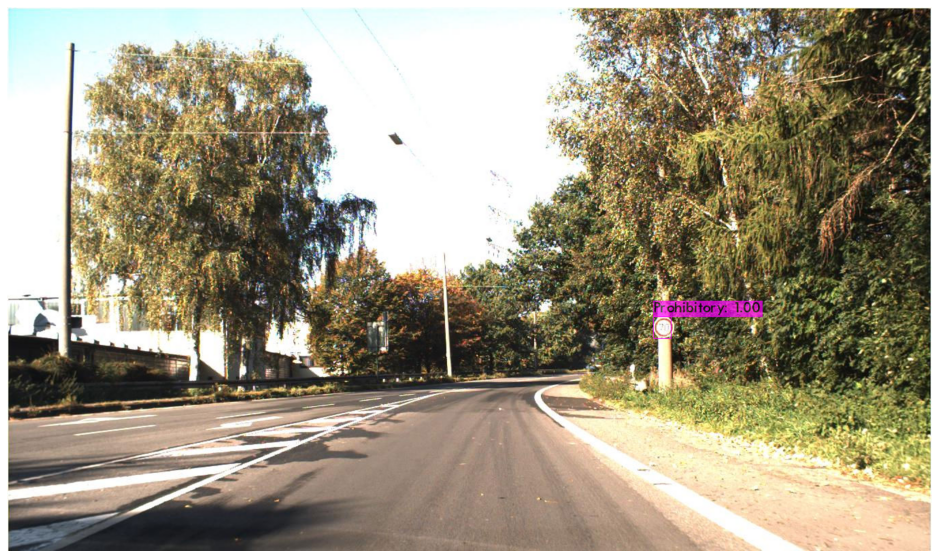

In [70]:
!./darknet detector test $data_file $cfg_file $weights /content/GTSDB/GTSDB_jpg/00018.jpg
imShow('predictions.jpg')

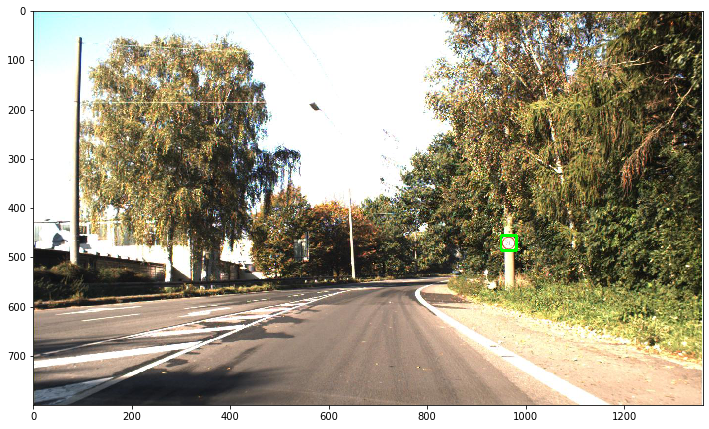

In [ ]:
draw_boxes(Image.open('/content/GTSDB/GTSDB_jpg/00018.jpg'), image_info['00018.ppm'])

In [ ]:
X_test

['00121.ppm',
 '00199.ppm',
 '00355.ppm',
 '00689.ppm',
 '00423.ppm',
 '00701.ppm',
 '00076.ppm',
 '00450.ppm',
 '00426.ppm',
 '00317.ppm',
 '00624.ppm',
 '00347.ppm',
 '00896.ppm',
 '00515.ppm',
 '00151.ppm',
 '00384.ppm',
 '00081.ppm',
 '00167.ppm',
 '00101.ppm',
 '00039.ppm',
 '00467.ppm',
 '00379.ppm',
 '00255.ppm',
 '00387.ppm',
 '00772.ppm',
 '00542.ppm',
 '00216.ppm',
 '00295.ppm',
 '00483.ppm',
 '00818.ppm',
 '00077.ppm',
 '00201.ppm',
 '00742.ppm',
 '00898.ppm',
 '00078.ppm',
 '00066.ppm',
 '00393.ppm',
 '00184.ppm',
 '00520.ppm',
 '00033.ppm',
 '00732.ppm',
 '00435.ppm',
 '00884.ppm',
 '00741.ppm',
 '00224.ppm',
 '00425.ppm',
 '00488.ppm',
 '00010.ppm',
 '00841.ppm',
 '00065.ppm',
 '00119.ppm',
 '00725.ppm',
 '00570.ppm',
 '00097.ppm',
 '00564.ppm',
 '00054.ppm',
 '00297.ppm',
 '00408.ppm',
 '00857.ppm',
 '00723.ppm',
 '00635.ppm',
 '00134.ppm',
 '00482.ppm',
 '00619.ppm',
 '00231.ppm',
 '00422.ppm',
 '00456.ppm',
 '00869.ppm',
 '00468.ppm',
 '00217.ppm',
 '00158.ppm',
 '0037